# Problem gapowicza w transporcie publicznym
### Autorzy: Sebastian Halicki, Zofia Kozieł, Lizaveta Miastouskaya

In [1]:
# biblioteki
using Random, Distributions, Statistics, DataFrames

In [2]:
# # parametry
ticket_price = 5.0 # cena biletu
ticket_penalty = 50.0 # cena mandatu
control_number = 10 # liczba kontroli
control_cost = 20 # cena pojedynczej kontroli
ndays = 30 # liczba dni dla których modelujemy - miesiąc


30

In [3]:
# Symulacja dla jednego dnia
function one_day(control_number, ticket_price, ticket_penalty, control_cost;
    max_pas = 60, # maksymalna liczba pasażerów
    average_pas = 20, # średnia liczba pasażerów
    bus_number = 100, # liczba kursów w ciągu dnia
    ride_cost = 100, # koszt przejazdu bez pasażerów
    passenger_cost = 3.5, # dodatkowy koszt związany z przewozem pasażera
    control_ability = 30 # liczba pasażerów, których kontrola na pewno sprawdzi
    )

    p_freerider = ticket_price/(ticket_price+ticket_penalty)

    tot_freeriders = 0
    paid = 0
    day_revenue = 0.0
    pois = Distributions.Poisson(average_pas)

    for bus in 1:bus_number
        freerider_num = 0 
        bus_revenue = 0.0
        controler_cost = 0.0
        bus_penalty = 0.0
        l_pasazerow = rand(pois) #losowanie liczby pasażerów dla autobusu
        pas_number = min(l_pasazerow, max_pas) #ograniczenie liczby pasażerów do pojemności autobusu
        for passenger in 1:pas_number
            if rand()<p_freerider #dla każdego pasażera następuje losowanie czy jedzie bez biletu
                freerider_num +=1
            else
                paid +=1
            end
        end

        if (control_number>0) #losowanie czy kontroler sprawdzi autobus
            
            if pas_number <= control_ability # jeśli pasażerów jest mniej niż wynosi limit podczas kontroli to wszyscy zostaną sprawdzeni
                bus_penalty = freerider_num * ticket_penalty #suma kar biletowych za wszystkich gapowiczów
            else
                for free in 1:freerider_num #dla każdego gapowicza jest szansa na ukrycie się w tłumie przed kontrolerem
                    if rand()< 1/pas_number
                        bus_penalty += ticket_penalty
                    end
                end
            end
            control_number -= 1 # zmniejszamy liczbę kontrol o jeden
            controler_cost =+ control_cost
        end
        bus_revenue = bus_penalty + paid * ticket_price - pas_number * passenger_cost - controler_cost - ride_cost #funkcja celu uwzględnia kary dla gapowiczów, opłaty za bilety, koszt przejazdu i pasażerów oraz koszt kontroli
        day_revenue += bus_revenue
        tot_freeriders += freerider_num
    end
    (day_revenue = day_revenue, tot_freeriders = tot_freeriders)
end


one_day (generic function with 1 method)

In [4]:
o = one_day(control_number, ticket_price, ticket_penalty, control_cost)

(day_revenue = 455525.0, tot_freeriders = 195)

In [5]:
function year(control_number, ticket_price, ticket_penalty, control_cost; ndays = ndays)

    total_revenue = 0.0
    day_revenue = Float64[]

    for day in 1:ndays
        day_rev, day_freeriders = one_day(control_number, ticket_price, ticket_penalty, control_cost)
        total_revenue += day_rev
        push!(day_revenue, day_rev)
    end
    (total_revenue = total_revenue, day_revenue = day_revenue)
end
year(control_number, ticket_price, ticket_penalty, control_cost)

(total_revenue = 1.3269345e7, day_revenue = [447168.0, 436046.0, 457227.5, 430149.0, 448407.5, 442142.5, 427039.5, 439121.0, 436085.5, 438217.5  …  432781.5, 460183.0, 418607.0, 424627.5, 451044.5, 430696.0, 452014.0, 425407.0, 470093.0, 433527.5])

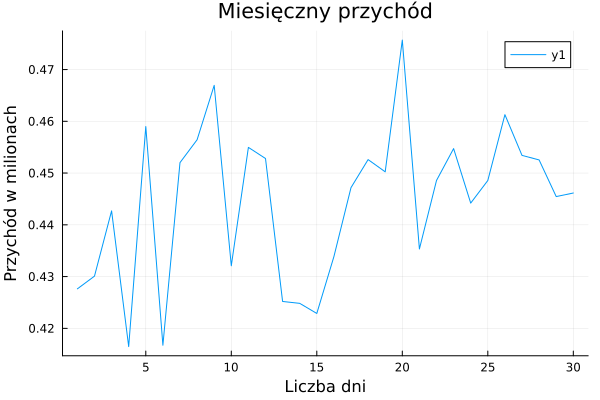

In [6]:
Random.seed!(81)
year_res = year(control_number, ticket_price, ticket_penalty, control_cost)

using Plots
plot(year_res.day_revenue/1000000)
xlabel!("Liczba dni")
ylabel!("Przychód w milionach")
title!("Miesięczny przychód")

In [7]:
function run(control_number, ticket_price, ticket_penalty, control_cost; n_iter = 1000, ndays = ndays)
    df = DataFrame(year(control_number, ticket_price, ticket_penalty, control_cost) for _ in 1:n_iter)
    (control_number = control_number,
    ticket_price = ticket_price,
    ticket_penalty = ticket_penalty,
    control_cost = control_cost,
    revenue_mean = mean(df.total_revenue),
    revenue_std = std(df.total_revenue)
    )
end

run (generic function with 1 method)

In [8]:
run(control_number, ticket_price, ticket_penalty, control_cost)

(control_number = 10, ticket_price = 5.0, ticket_penalty = 50.0, control_cost = 20, revenue_mean = 1.3286707098e7, revenue_std = 67025.65358639989)

In [9]:
df = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for ticket_penalty in 10.0:5.0:80.0, control_number in 10:10:100)

150×6 DataFrame. Omitted printing of 2 columns
│ Row │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│     │ Int64          │ Float64      │ Float64        │ Int64        │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1   │ 10             │ 5.0          │ 10.0           │ 20           │
│ 2   │ 10             │ 5.0          │ 15.0           │ 20           │
│ 3   │ 10             │ 5.0          │ 20.0           │ 20           │
│ 4   │ 10             │ 5.0          │ 25.0           │ 20           │
│ 5   │ 10             │ 5.0          │ 30.0           │ 20           │
│ 6   │ 10             │ 5.0          │ 35.0           │ 20           │
│ 7   │ 10             │ 5.0          │ 40.0           │ 20           │
│ 8   │ 10             │ 5.0          │ 45.0           │ 20           │
│ 9   │ 10             │ 5.0          │ 50.0           │ 20           │
│ 10  │ 10             │ 5.0          │ 55.0           │ 20           │
⋮
│ 140 │ 100            │ 5.0          │ 30.0           │ 20           │
│ 141 │ 100            │ 5.0          │ 35.0           │ 20           │
│ 142 │ 100            │ 5.0          │ 40.0           │ 20           │
│ 143 │ 100            │ 5.0          │ 45.0           │ 20           │
│ 144 │ 100            │ 5.0          │ 50.0           │ 20           │
│ 145 │ 100            │ 5.0          │ 55.0           │ 20           │
│ 146 │ 100            │ 5.0          │ 60.0           │ 20           │
│ 147 │ 100            │ 5.0          │ 65.0           │ 20           │
│ 148 │ 100            │ 5.0          │ 70.0           │ 20           │
│ 149 │ 100            │ 5.0          │ 75.0           │ 20           │
│ 150 │ 100            │ 5.0          │ 80.0           │ 20           │

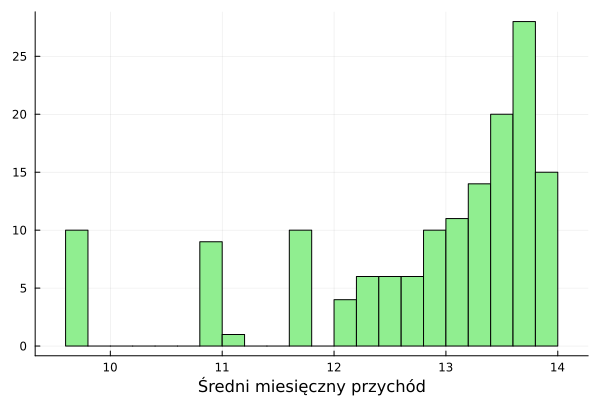

In [10]:
using Plots

histogram(df.revenue_mean/1000000, 
    legend = false, 
    xlabel = "Średni miesięczny przychód", 
    color="lightgreen",
    bins=25)


In [11]:
best_row = argmax(df.revenue_mean)

150

In [12]:
df[best_row,:]

DataFrameRow. Omitted printing of 2 columns
│ Row │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│     │ Int64          │ Float64      │ Float64        │ Int64        │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 150 │ 100            │ 5.0          │ 80.0           │ 20           │

In [13]:
vectors_bus = Int[]
vectors_control = Int[]
vectors_revenue = Float64[]
unique_bus = unique(df.ticket_penalty)

for i in unique_bus
    filter = findall(==(i), df.ticket_penalty)
    vector_bus = df.ticket_penalty[filter]
    vector_control = df.control_number[filter]
    vector_revenue = df.revenue_mean[filter]

    append!(vectors_bus, vector_bus)
    append!(vectors_control, vector_control)
    append!(vectors_revenue, vector_revenue)
end

In [14]:
function heatmap_data(column1, column2, column3)
    uni = unique(column1)
    vectors1 = []
    vectors2 = []
    vectors3 = []
    for i in uni
        filter = findall(==(i), column1)
        vector1 = column1[filter]
        vector2 = column2[filter]
        vector3 = column3[filter]

        append!(vectors1,vector1)
        append!(vectors2,vector2)
        append!(vectors3,vector3)
    end


    uni_size_1 = size(unique(column1),1)
    uni_size_2 = size(unique(column2),1)
    uni_1 = unique(column1)
    uni_2 = unique(column2)
    
    data_heat = reshape(vectors3, uni_size_1, uni_size_2)

    (data_heat=data_heat, uni_1=uni_1, uni_2=uni_2)
end


heatmap_data (generic function with 1 method)

In [15]:
data_heat, uni_control, uni_ticket = heatmap_data(df.ticket_penalty, df.control_number, df.revenue_mean)


(data_heat = Any[9.600623055e6 1.0949685797e7 … 1.36502487745e7 1.38239667425e7; 9.61552364e6 1.0967650473e7 … 1.3669790538e7 1.3839311496e7; … ; 1.0920146436e7 1.1770564242e7 … 1.37780966055e7 1.3940969391e7; 1.0929321912e7 1.1786277143e7 … 1.3799290029e7 1.3969637463e7], uni_1 = [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0], uni_2 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [74]:
heatmap( uni_ticket, uni_control, data_heat',
    title = "Heatmap - Średnie przychody",
    xlabel = "Liczba kontroli",
    ylabel = "Wartość mandatu")
    savefig("heatmap")

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\heatmap.png"

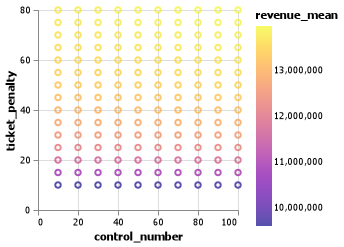

In [17]:
using VegaLite
df |> @vlplot(:point, x=:control_number, y=:ticket_penalty, color={:revenue_mean, scale={scheme=:plasma}})

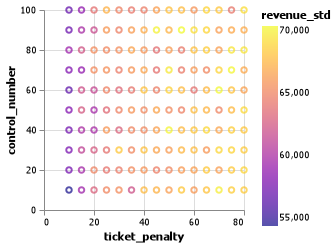

In [18]:
using VegaLite
df |> @vlplot(:point, x=:ticket_penalty, y=:control_number, color={:revenue_std, scale={scheme=:plasma}})

In [19]:
# usuwanie obserwacji nie pareto optymalnych
df1 = select(df, :control_number,:revenue_mean, :revenue_std)
df1 = sort(df1,[:revenue_std])
df1
pareto = df1[1:1,:]
foreach(row -> row.revenue_mean > pareto.revenue_mean[end] && push!(pareto, row), eachrow(df1))


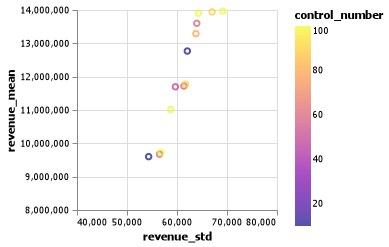

In [71]:
using VegaLite
p0 = pareto |> @vlplot(:point, x={:revenue_std, scale = {domain = (40000,80000)}}, y={:revenue_mean, scale = {domain = (8000000,14000000)}} , color={:control_number, scale={scheme=:plasma}})

In [73]:
using FileIO
p0 |>  FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/pareto0.png")

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


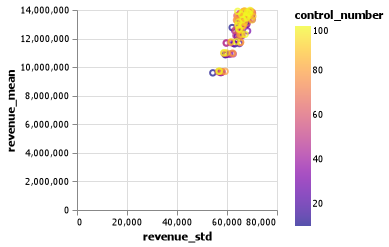

In [69]:
using VegaLite
df |> @vlplot(:point, x=:revenue_std, y=:revenue_mean , color={:control_number, scale={scheme=:plasma}})

In [23]:
# usuwanie obserwacji nie pareto optymalnych
df2 = select(df, :ticket_penalty,:revenue_mean, :revenue_std)
df2 = sort(df2,[:revenue_std])
df2
pareto1 = df2[1:1,:]
foreach(row -> row.revenue_mean > pareto1.revenue_mean[end] && push!(pareto1, row), eachrow(df2))


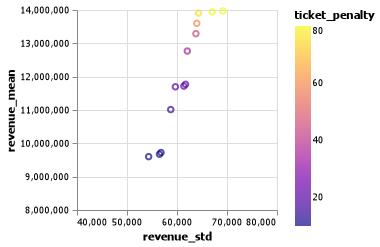

In [70]:
using VegaLite
p1 = pareto1|> @vlplot(:point, x={:revenue_std, scale = {domain = (40000,80000)}}, y={:revenue_mean, scale = {domain = (8000000,14000000)}} , color={:ticket_penalty, scale={scheme=:plasma}})

In [72]:
using FileIO
p1 |> FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/pareto1.png")



┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


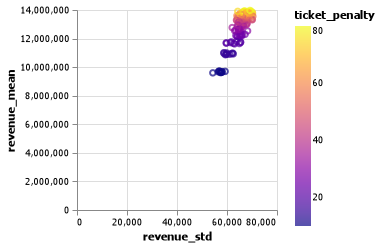

In [26]:
using VegaLite
df |> @vlplot(:point, x=:revenue_std, y=:revenue_mean , color={:ticket_penalty, scale={scheme=:plasma}})

## Analiza Wrażliwości

In [27]:
# ticket price

df_list = []

dataframe = DataFrame()

for ticket_price in 2.0:2.0:20.0
 df_ticket = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for ticket_penalty in 10.0:5.0:80.0, control_number in 10:10:100)
 push!(df_list, df_ticket)
 append!(dataframe, df_ticket)
end


In [28]:
using Colors
cols = range(colorant"purple", stop=colorant"aquamarine", length=size(unique(dataframe.revenue_mean),1))

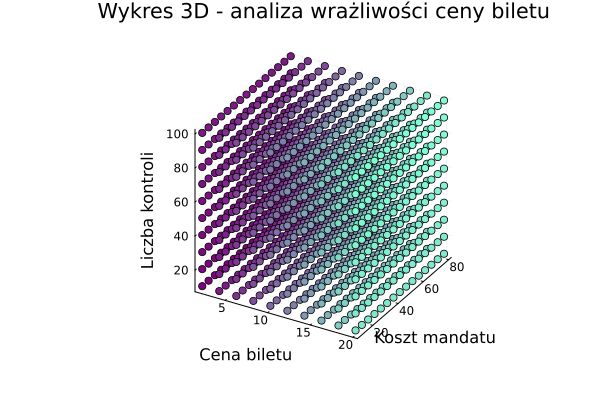

In [29]:
using Plots


scatter3d(dataframe.ticket_price,dataframe.ticket_penalty,dataframe.control_number,color=cols, 
legend=false)
xaxis!("Cena biletu")
yaxis!("Koszt mandatu")
zaxis!("Liczba kontroli")
title!("Wykres 3D - analiza wrażliwości ceny biletu")

In [30]:
savefig("3d_1")

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\3d_1.png"

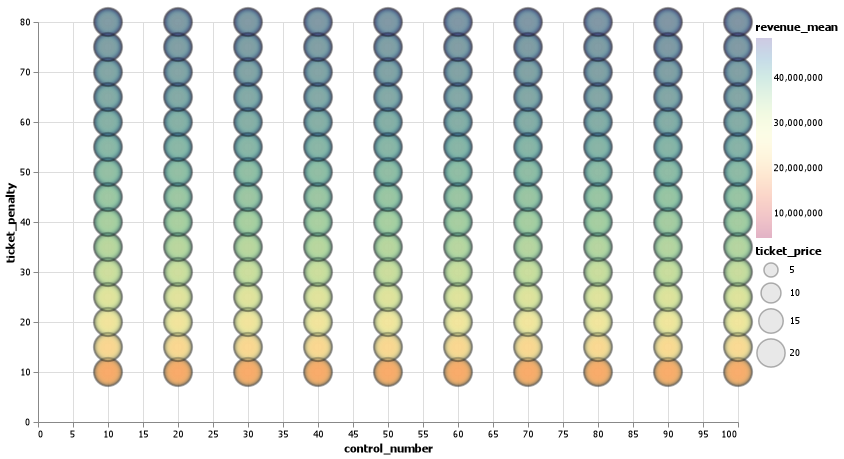

In [31]:
using VegaLite
using ColorSchemes

b1 = dataframe |> @vlplot(width=700, height=400,
 mark={
    :circle, opacity=0.3, stroke =:black
    }, 
    x=:control_number, 
    y=:ticket_penalty , 
    color={
        :revenue_mean, scale={scheme=:spectral}
        },
    size =
    {
        :ticket_price, scale={range=[0,800]}
    })


In [32]:
using FileIO
b1 |>  FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/bubble1.png")


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


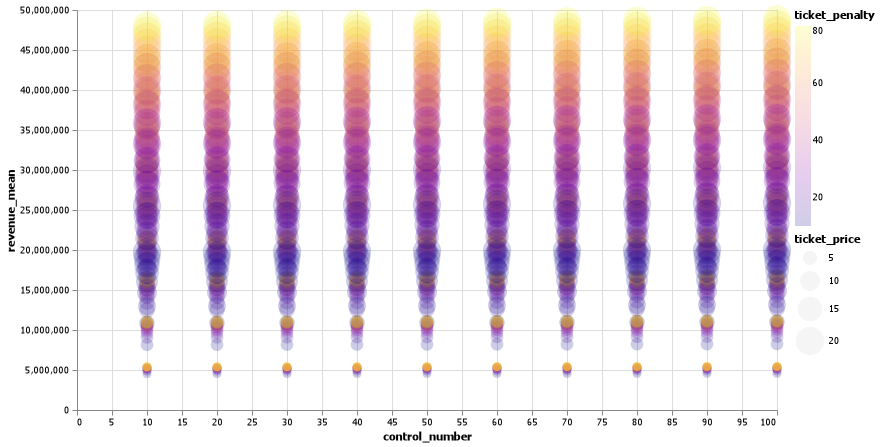

In [33]:
using VegaLite
using ColorSchemes

b2 = dataframe |> @vlplot(width=700, height=400,
 mark={
    :circle, opacity=0.2
    }, 
    x=:control_number, 
    y=:revenue_mean , 
    color={
        :ticket_penalty, scale={scheme=:plasma}
        },
    size =
    {
        :ticket_price, scale={range=[0,800]}
    })

In [34]:
using FileIO
b2 |>  FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/bubble2.png")

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


In [35]:
best_row_list = []

for i in 1:length(df_list)
    best_row = argmax(df_list[i].revenue_mean)
    push!(best_row_list, best_row)
end 


In [36]:
df_best_rows_ticket = DataFrame(df_list[i][best_row_list[i],:] for i in 1:length(df_list))
select!(df_best_rows_ticket, Not([:control_cost, :revenue_std]))

10×4 DataFrame
│ Row │ control_number │ ticket_price │ ticket_penalty │ revenue_mean │
│     │ Int64          │ Float64      │ Float64        │ Float64      │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1   │ 100            │ 2.0          │ 80.0           │ 5.45859e6    │
│ 2   │ 100            │ 4.0          │ 80.0           │ 1.11966e7    │
│ 3   │ 100            │ 6.0          │ 80.0           │ 1.66637e7    │
│ 4   │ 100            │ 8.0          │ 80.0           │ 2.18928e7    │
│ 5   │ 100            │ 10.0         │ 80.0           │ 2.68872e7    │
│ 6   │ 100            │ 12.0         │ 80.0           │ 3.16618e7    │
│ 7   │ 100            │ 14.0         │ 80.0           │ 3.62254e7    │
│ 8   │ 100            │ 16.0         │ 80.0           │ 4.06248e7    │
│ 9   │ 100            │ 18.0         │ 80.0           │ 4.48e7       │
│ 10  │ 100            │ 20.0         │ 80.0           │ 4.88483e7    │

In [37]:
# Tabela przedstawiająca najlepsze wiersze dla poszczególnych cen biletów
using PrettyTables

headers = (["Liczba kontroli", "Cena biletu", "Koszt mandatu", "Średnie przychody"]);
pretty_table(df_best_rows_ticket, backend = Val(:latex), header = headers, alignment = :c)

\begin{tabular}{cccc}
  \hline
  \textbf{Liczba kontroli} & \textbf{Cena biletu} & \textbf{Koszt mandatu} & \textbf{Średnie przychody} \\\hline
  100 & 2.0 & 80.0 & 5.45859e6 \\
  100 & 4.0 & 80.0 & 1.11966e7 \\
  100 & 6.0 & 80.0 & 1.66637e7 \\
  100 & 8.0 & 80.0 & 2.18928e7 \\
  100 & 10.0 & 80.0 & 2.68872e7 \\
  100 & 12.0 & 80.0 & 3.16618e7 \\
  100 & 14.0 & 80.0 & 3.62254e7 \\
  100 & 16.0 & 80.0 & 4.06248e7 \\
  100 & 18.0 & 80.0 & 4.48e7 \\
  100 & 20.0 & 80.0 & 4.88483e7 \\\hline
\end{tabular}


In [38]:
# control_cost

df_list2 = []
dataframe2 = DataFrame()

for control_cost in 10.0:10.0:40.0
    df_control = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for ticket_penalty in 10.0:5.0:80.0, control_number in 10:10:100)
    push!(df_list2, df_control)
    append!(dataframe2, df_control)
end

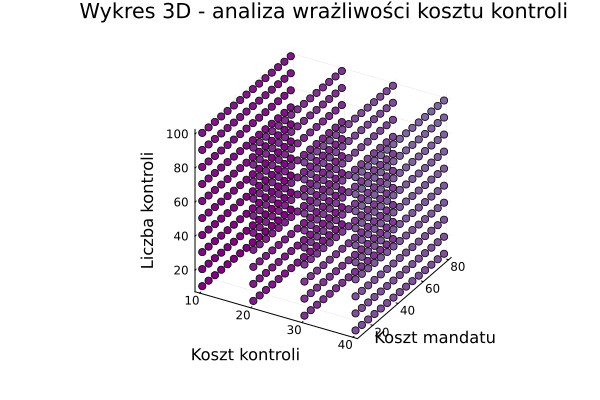

┌ Warning: Indices Base.OneTo(1500) of attribute `seriescolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `linecolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `fillcolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `markercolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `seriescolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `linecolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:14

In [39]:
scatter3d(dataframe2.control_cost , dataframe2.ticket_penalty, dataframe2.control_number,color=cols , legend=false)
xaxis!("Koszt kontroli")
yaxis!("Koszt mandatu")
zaxis!("Liczba kontroli")
title!("Wykres 3D - analiza wrażliwości kosztu kontroli")

In [40]:
savefig("3d_2")

┌ Warning: Indices Base.OneTo(1500) of attribute `seriescolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `linecolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `fillcolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `markercolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `seriescolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:141
┌ Warning: Indices Base.OneTo(1500) of attribute `linecolor` does not match data indices 1:600.
└ @ Plots C:\Users\zosia\.julia\packages\Plots\QWCV6\src\utils.jl:14

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\3d_2.png"

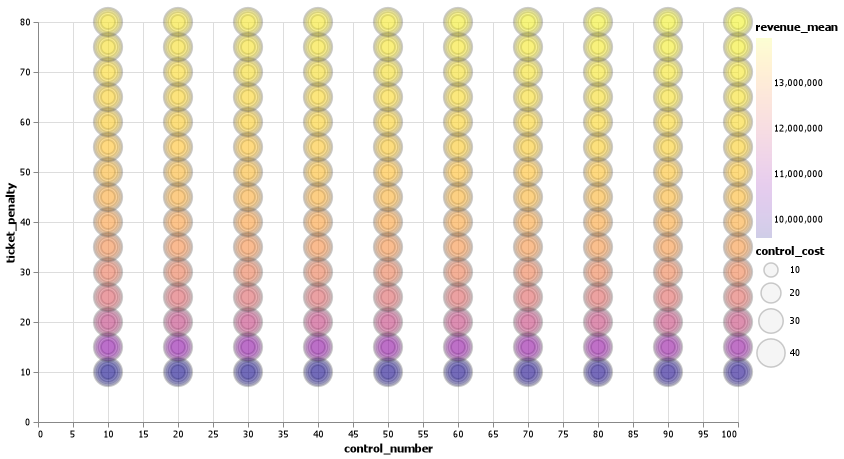

In [41]:
using VegaLite
b3 = dataframe2 |> @vlplot(width=700, height=400,
 mark={
    :circle, stroke=:black,strikewidth=1, opacity=0.2
    }, 
    x=:control_number, 
    y=:ticket_penalty , 
    color={
        :revenue_mean, scale={scheme=:plasma}
        },
    size =
    {
        :control_cost, scale={range=[0,800]}
    })

In [42]:
using FileIO
b3 |>  FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/bubble3.png")


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


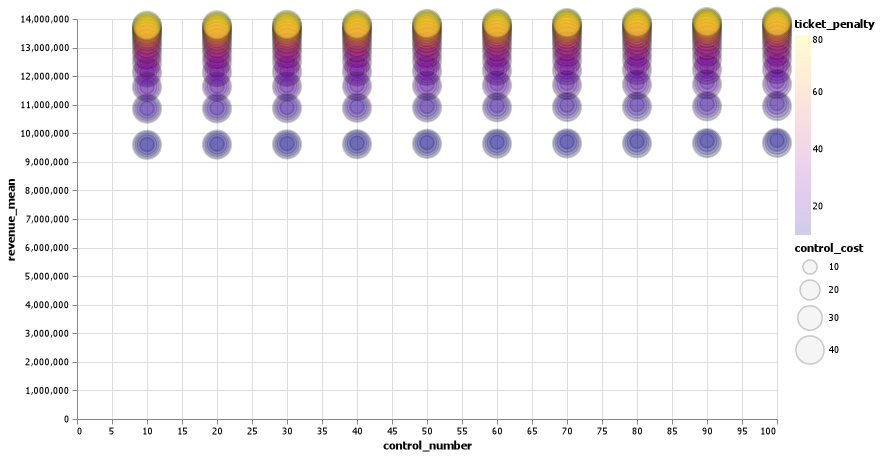

In [43]:
using VegaLite
b4 = dataframe2 |> @vlplot(width=700, height=400,
 mark={
    :circle, stroke=:black,strikewidth=1, opacity=0.2
    }, 
    x=:control_number, 
    y=:revenue_mean , 
    color={
        :ticket_penalty, scale={scheme=:plasma}
        },
    size =
    {
        :control_cost, scale={range=[0,800]}
    })

In [44]:
using FileIO
b4 |> FileIO.save("C:/Users/zosia/Desktop/MIESI MAGISTERKA/SEM 2/ZMS/zadania_raporty/końcowy/bubble4.png")


┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\zosia\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


In [45]:
best_row_list2 = []

for i in 1:length(df_list2)
    best_row = argmax(df_list2[i].revenue_mean)
    push!(best_row_list2, best_row)
end 

In [46]:
df_best_rows_control = DataFrame(df_list2[i][best_row_list2[i],:] for i in 1:length(df_list2))
select!(df_best_rows_control, Not([:ticket_price, :revenue_std]))

4×4 DataFrame
│ Row │ control_number │ ticket_penalty │ control_cost │ revenue_mean │
│     │ Int64          │ Float64        │ Float64      │ Float64      │
├─────┼────────────────┼────────────────┼──────────────┼──────────────┤
│ 1   │ 100            │ 80.0           │ 10.0         │ 1.39907e7    │
│ 2   │ 100            │ 80.0           │ 20.0         │ 1.39697e7    │
│ 3   │ 100            │ 80.0           │ 30.0         │ 1.39355e7    │
│ 4   │ 100            │ 80.0           │ 40.0         │ 1.39051e7    │

In [47]:
# Tabela przedstawiająca najlepsze wiersze dla poszczególnych cen kontroli

headers = (["Liczba kontroli", "Koszt mandatu", "Koszt kontroli","Średnie przychody"]);
pretty_table(df_best_rows_control, backend = Val(:latex), header = headers, alignment = :c)

\begin{tabular}{cccc}
  \hline
  \textbf{Liczba kontroli} & \textbf{Koszt mandatu} & \textbf{Koszt kontroli} & \textbf{Średnie przychody} \\\hline
  100 & 80.0 & 10.0 & 1.39907e7 \\
  100 & 80.0 & 20.0 & 1.39697e7 \\
  100 & 80.0 & 30.0 & 1.39355e7 \\
  100 & 80.0 & 40.0 & 1.39051e7 \\\hline
\end{tabular}


## Model Regresji

In [1]:
data_regression1 = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for control_number in 10:5:100)


In [49]:
data_regression2 = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for control_cost in 10:5:100)

19×6 DataFrame. Omitted printing of 2 columns
│ Row │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│     │ Int64          │ Float64      │ Float64        │ Int64        │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1   │ 10             │ 5.0          │ 50.0           │ 10           │
│ 2   │ 10             │ 5.0          │ 50.0           │ 15           │
│ 3   │ 10             │ 5.0          │ 50.0           │ 20           │
│ 4   │ 10             │ 5.0          │ 50.0           │ 25           │
│ 5   │ 10             │ 5.0          │ 50.0           │ 30           │
│ 6   │ 10             │ 5.0          │ 50.0           │ 35           │
│ 7   │ 10             │ 5.0          │ 50.0           │ 40           │
│ 8   │ 10             │ 5.0          │ 50.0           │ 45           │
│ 9   │ 10             │ 5.0          │ 50.0           │ 50           │
│ 10  │ 10             │ 5.0          │ 50.0           │ 55           │
│ 11  │ 10             │ 5.0          │ 50.0           │ 60           │
│ 12  │ 10             │ 5.0          │ 50.0           │ 65           │
│ 13  │ 10             │ 5.0          │ 50.0           │ 70           │
│ 14  │ 10             │ 5.0          │ 50.0           │ 75           │
│ 15  │ 10             │ 5.0          │ 50.0           │ 80           │
│ 16  │ 10             │ 5.0          │ 50.0           │ 85           │
│ 17  │ 10             │ 5.0          │ 50.0           │ 90           │
│ 18  │ 10             │ 5.0          │ 50.0           │ 95           │
│ 19  │ 10             │ 5.0          │ 50.0           │ 100          │

In [50]:
data_regression3 = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for ticket_penalty in 10.0:2.5:200.0)

77×6 DataFrame. Omitted printing of 2 columns
│ Row │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│     │ Int64          │ Float64      │ Float64        │ Int64        │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1   │ 10             │ 5.0          │ 10.0           │ 20           │
│ 2   │ 10             │ 5.0          │ 12.5           │ 20           │
│ 3   │ 10             │ 5.0          │ 15.0           │ 20           │
│ 4   │ 10             │ 5.0          │ 17.5           │ 20           │
│ 5   │ 10             │ 5.0          │ 20.0           │ 20           │
│ 6   │ 10             │ 5.0          │ 22.5           │ 20           │
│ 7   │ 10             │ 5.0          │ 25.0           │ 20           │
│ 8   │ 10             │ 5.0          │ 27.5           │ 20           │
│ 9   │ 10             │ 5.0          │ 30.0           │ 20           │
│ 10  │ 10             │ 5.0          │ 32.5           │ 20           │
⋮
│ 67  │ 10             │ 5.0          │ 175.0          │ 20           │
│ 68  │ 10             │ 5.0          │ 177.5          │ 20           │
│ 69  │ 10             │ 5.0          │ 180.0          │ 20           │
│ 70  │ 10             │ 5.0          │ 182.5          │ 20           │
│ 71  │ 10             │ 5.0          │ 185.0          │ 20           │
│ 72  │ 10             │ 5.0          │ 187.5          │ 20           │
│ 73  │ 10             │ 5.0          │ 190.0          │ 20           │
│ 74  │ 10             │ 5.0          │ 192.5          │ 20           │
│ 75  │ 10             │ 5.0          │ 195.0          │ 20           │
│ 76  │ 10             │ 5.0          │ 197.5          │ 20           │
│ 77  │ 10             │ 5.0          │ 200.0          │ 20           │

In [51]:
data_regression4 = DataFrame(run(control_number, ticket_price, ticket_penalty, control_cost) for ticket_price in 1.0:0.25:90.0)

357×6 DataFrame. Omitted printing of 2 columns
│ Row │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│     │ Int64          │ Float64      │ Float64        │ Int64        │
├─────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1   │ 10             │ 1.0          │ 50.0           │ 20           │
│ 2   │ 10             │ 1.25         │ 50.0           │ 20           │
│ 3   │ 10             │ 1.5          │ 50.0           │ 20           │
│ 4   │ 10             │ 1.75         │ 50.0           │ 20           │
│ 5   │ 10             │ 2.0          │ 50.0           │ 20           │
│ 6   │ 10             │ 2.25         │ 50.0           │ 20           │
│ 7   │ 10             │ 2.5          │ 50.0           │ 20           │
│ 8   │ 10             │ 2.75         │ 50.0           │ 20           │
│ 9   │ 10             │ 3.0          │ 50.0           │ 20           │
│ 10  │ 10             │ 3.25         │ 50.0           │ 20           │
⋮
│ 347 │ 10             │ 87.5         │ 50.0           │ 20           │
│ 348 │ 10             │ 87.75        │ 50.0           │ 20           │
│ 349 │ 10             │ 88.0         │ 50.0           │ 20           │
│ 350 │ 10             │ 88.25        │ 50.0           │ 20           │
│ 351 │ 10             │ 88.5         │ 50.0           │ 20           │
│ 352 │ 10             │ 88.75        │ 50.0           │ 20           │
│ 353 │ 10             │ 89.0         │ 50.0           │ 20           │
│ 354 │ 10             │ 89.25        │ 50.0           │ 20           │
│ 355 │ 10             │ 89.5         │ 50.0           │ 20           │
│ 356 │ 10             │ 89.75        │ 50.0           │ 20           │
│ 357 │ 10             │ 90.0         │ 50.0           │ 20           │

Na wykresie poniżej możemy zaobserwować jak wpływają różne zmienne na średnie przychody.
W celu lepszego przedstawienie zależności na koljenym wykresie przedstawione zostały zlogarytmowane wartości zmiennych, które przypominały eksponentę.

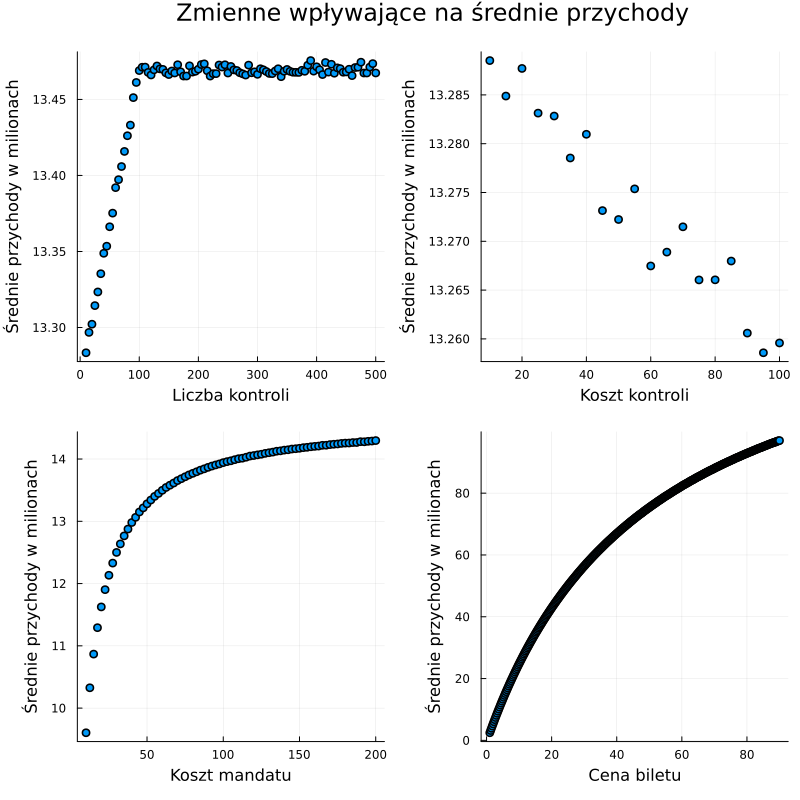

In [83]:
# sprawdzenie zależności ceteris paribus
using Plots

s1 = scatter(data_regression1.control_number, data_regression1.revenue_mean/1000000, ylabel="Średnie przychody w milionach", xlabel="Liczba kontroli")
s2 = scatter(data_regression2.control_cost, data_regression2.revenue_mean/1000000, ylabel="Średnie przychody w milionach", xlabel="Koszt kontroli")
s3 = scatter(data_regression3.ticket_penalty, data_regression3.revenue_mean/1000000, ylabel="Średnie przychody w milionach", xlabel="Koszt mandatu")
s4 = scatter(data_regression4.ticket_price,  data_regression4.revenue_mean/1000000, ylabel="Średnie przychody w milionach", xlabel="Cena biletu")

plot(s1,s2,s3,s4, layout = (2,2), size = (800,800), legend=false,plot_title = "Zmienne wpływające na średnie przychody")


In [84]:
savefig("ceteris_paribus")

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\ceteris_paribus.png"

### Model
- W ramach analizy wrażliwości zdecydowaliśmy się na konstrukcję modelu regresji, bazującego na jednej ze zmiennych uwzględnionych w tej analizie czyli cenie biletu
- regresja została przeprowadzona dla bazy danych - dataframe

In [54]:
d_reg = dataframe

1500×6 DataFrame. Omitted printing of 2 columns
│ Row  │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│      │ Int64          │ Float64      │ Float64        │ Int64        │
├──────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1    │ 10             │ 2.0          │ 10.0           │ 20           │
│ 2    │ 10             │ 2.0          │ 15.0           │ 20           │
│ 3    │ 10             │ 2.0          │ 20.0           │ 20           │
│ 4    │ 10             │ 2.0          │ 25.0           │ 20           │
│ 5    │ 10             │ 2.0          │ 30.0           │ 20           │
│ 6    │ 10             │ 2.0          │ 35.0           │ 20           │
│ 7    │ 10             │ 2.0          │ 40.0           │ 20           │
│ 8    │ 10             │ 2.0          │ 45.0           │ 20           │
│ 9    │ 10             │ 2.0          │ 50.0           │ 20           │
│ 10   │ 10             │ 2.0          │ 55.0           │ 20           │
⋮
│ 1490 │ 100            │ 20.0         │ 30.0           │ 20           │
│ 1491 │ 100            │ 20.0         │ 35.0           │ 20           │
│ 1492 │ 100            │ 20.0         │ 40.0           │ 20           │
│ 1493 │ 100            │ 20.0         │ 45.0           │ 20           │
│ 1494 │ 100            │ 20.0         │ 50.0           │ 20           │
│ 1495 │ 100            │ 20.0         │ 55.0           │ 20           │
│ 1496 │ 100            │ 20.0         │ 60.0           │ 20           │
│ 1497 │ 100            │ 20.0         │ 65.0           │ 20           │
│ 1498 │ 100            │ 20.0         │ 70.0           │ 20           │
│ 1499 │ 100            │ 20.0         │ 75.0           │ 20           │
│ 1500 │ 100            │ 20.0         │ 80.0           │ 20           │

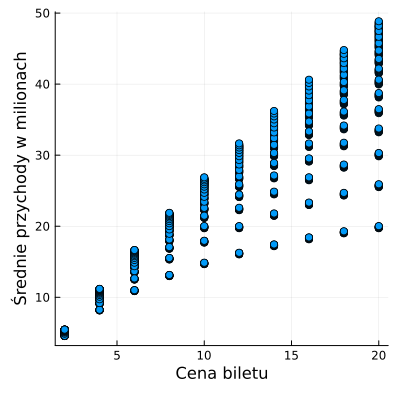

In [80]:
# zależności pokazane na danych do regresji
s_reg2 = scatter(d_reg.ticket_price,d_reg.revenue_mean/1000000, xlabel="Cena biletu", ylabel="Średnie przychody w milionach")

plot(s_reg2, size = (400,400), legend=false)


In [82]:
savefig("ticket_price_reg")

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\ticket_price_reg.png"

Finalnie zdecydowaliśmy się na model liniowy

In [57]:
# Podział danych na treningowe i testowe
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(d_reg, .70)

(1047×6 DataFrame. Omitted printing of 2 columns
│ Row  │ control_number │ ticket_price │ ticket_penalty │ control_cost │
│      │ Int64          │ Float64      │ Float64        │ Int64        │
├──────┼────────────────┼──────────────┼────────────────┼──────────────┤
│ 1    │ 10             │ 2.0          │ 10.0           │ 20           │
│ 2    │ 10             │ 2.0          │ 20.0           │ 20           │
│ 3    │ 10             │ 2.0          │ 30.0           │ 20           │
│ 4    │ 10             │ 2.0          │ 40.0           │ 20           │
│ 5    │ 10             │ 2.0          │ 50.0           │ 20           │
│ 6    │ 10             │ 2.0          │ 55.0           │ 20           │
│ 7    │ 10             │ 2.0          │ 60.0           │ 20           │
│ 8    │ 10             │ 2.0          │ 65.0           │ 20           │
│ 9    │ 10             │ 2.0          │ 70.0           │ 20           │
│ 10   │ 10             │ 2.0          │ 75.0           │ 20           │
⋮


In [58]:
using GLM
fm = @formula(revenue_mean ~ ticket_price)
linear_reg = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

revenue_mean ~ 1 + ticket_price

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.     Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   3.22598e6      3.18967e5  10.11    <1e-22   2.6001e6  3.85187e6
ticket_price  1.89718e6  25828.5        73.45    <1e-99   1.8465e6  1.94786e6
─────────────────────────────────────────────────────────────────────────────

In [59]:
using PrettyTables

headers  = (["Zmienne objaśniające","Oszacowania","P-value"])
params = ["Stała", "Cena biletu"]
estimates = coef(linear_reg)./1000000
p_values = coeftable(linear_reg).cols[4]
data_tab  = hcat(params, estimates, p_values)

pretty_table(data_tab, backend=Val(:latex), header=headers, alignment=:c)

\begin{tabular}{ccc}
  \hline
  \textbf{Zmienne objaśniające} & \textbf{Oszacowania} & \textbf{P-value} \\\hline
  Stała & 3.22598 & 5.27352e-23 \\
  Cena biletu & 1.89718 & 0.0 \\\hline
\end{tabular}


In [60]:
r2(linear_reg)

0.8377415175427397

In [79]:
using Plots
using LaTeXStrings
scatter(train.ticket_price, train.revenue_mean, xlabel="Cena biletu", ylabel="Średnie przychody", smooth=:true)
annotate!(
  8.5,
  1000000000,
  latexstring(
    "y = $(round(coef(linear_reg)[2], digits = 2))x + $(round(coef(linear_reg)[1], digits = 2))"
  )
)

annotate!(
  8.5,
  800000000,
  latexstring(
    latexstring("r^2 = $(round(r2(linear_reg), digits = 2))")
  )
)
savefig("regression_plot")

"c:\\Users\\zosia\\Desktop\\MIESI MAGISTERKA\\SEM 2\\ZMS\\zadania_raporty\\końcowy\\regression_plot.png"

In [62]:
# prediction
revenue_predicted_test = predict(linear_reg, test)
revenue_predicted_train = predict(linear_reg, train)

# Test performance df
performance_testdf = DataFrame(revenue_actual = test[!,:revenue_mean], revenue_predicted = revenue_predicted_test)
performance_testdf.error = performance_testdf[!,:revenue_actual] - performance_testdf[!,:revenue_predicted]
performance_testdf.error_sq = performance_testdf.error .* performance_testdf.error

# Train performance df
performance_traindf = DataFrame(revenue_actual = train[!,:revenue_mean], revenue_predicted = revenue_predicted_train)
performance_traindf.error = performance_traindf[!,:revenue_actual] - performance_traindf[!,:revenue_predicted]
performance_traindf.error_sq = performance_traindf.error .* performance_traindf.error


1047-element Vector{Float64}:
 6.1340429941393125e12
 4.065389508589979e12
 3.401149855768181e12
 3.0783638814425117e12
 2.885682889321939e12
 2.8125428518310522e12
 2.754057682529357e12
 2.70743051097174e12
 2.6641236028129116e12
 2.635563766720533e12
 2.5988202365136396e12
 6.117573579246722e12
 4.722731533965009e12
 ⋮
 1.205969005527441e13
 2.0437710079629277e13
 4.809756880036172e13
 5.786058703918251e13
 4.472443326637628e14
 2.326942814445847e14
 1.1789874356422653e14
 2.1968510306776875e13
 5.858949683047298e12
 1.2682565588917535e13
 3.974772164173599e13
 5.896195464462563e13

In [63]:
#MAPE
    function mape(performance_df)
        mape = mean(abs.(performance_df.error./performance_df.revenue_actual))
    return mape
end

mape (generic function with 1 method)

In [64]:
# RMSE function defination
function rmse(performance_df)
    rmse = sqrt(mean(performance_df.error.*performance_df.error))
    return rmse
end

rmse (generic function with 1 method)

In [65]:
# Test Error
println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean Aboslute Percentage test error: ",mape(performance_testdf), "\n")
println("Root mean square test error: ",rmse(performance_testdf), "\n")
println("Mean square test error: ",mean(performance_testdf.error_sq), "\n")

Mean Absolute test error: 3.7662192726894715e6

Mean Aboslute Percentage test error: 0.18317421389443797

Root mean square test error: 5.290196892127076e6

Mean square test error: 2.7986183157470973e13



In [66]:
using PrettyTables
headers1 = ["Miara błędu prognozy","MAE", "MAPE", "RMSE","MSE"]
W_M = ["Wartość miary"]
MAE  = [ mean(abs.(performance_testdf.error))]
MAPE = [mape(performance_testdf)]
RMSE = [rmse(performance_testdf)]
MSE = [mean(performance_testdf.error_sq)]

data_pretty = hcat(W_M, MAE, MAPE, RMSE, MSE)

pretty_table(data_pretty, backend=Val(:latex),header = headers1, alignment=:c)



\begin{tabular}{ccccc}
  \hline
  \textbf{Miara błędu prognozy} & \textbf{MAE} & \textbf{MAPE} & \textbf{RMSE} & \textbf{MSE} \\\hline
  Wartość miary & 3.76622e6 & 0.183174 & 5.2902e6 & 2.79862e13 \\\hline
\end{tabular}


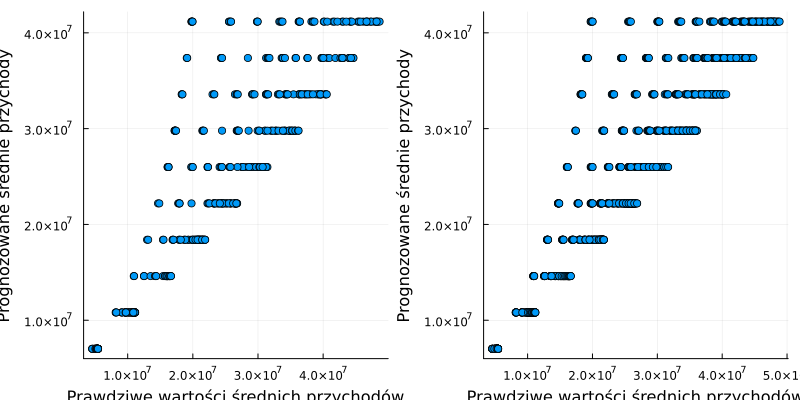

In [67]:
test_plot  = scatter(performance_testdf[!,:revenue_actual], performance_testdf[!,:revenue_predicted], ylabel = "Prognozowane średnie przychody", xlabel = "Prawdziwe wartości średnich przychodów", legend = false)
train_plot  = scatter(performance_traindf[!,:revenue_actual], performance_traindf[!,:revenue_predicted], ylabel = "Prognozowane średnie przychody", xlabel = "Prawdziwe wartości średnich przychodów", legend = false)

plot(test_plot, train_plot, layout=(1,2), size=(800, 400))

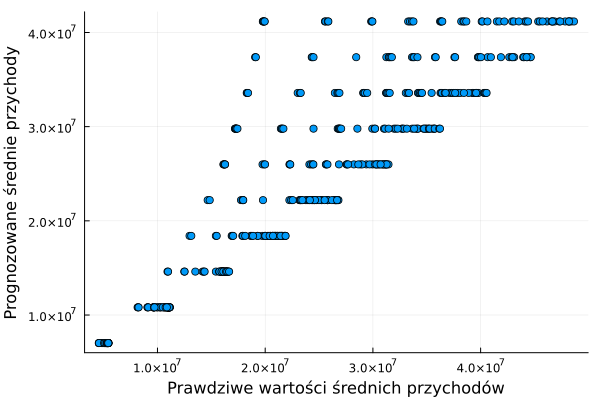

In [68]:
test_plot  = scatter(performance_testdf[!,:revenue_actual], performance_testdf[!,:revenue_predicted], ylabel = "Prognozowane średnie przychody", xlabel = "Prawdziwe wartości średnich przychodów", legend = false)
